In [1]:
import warnings 
warnings.filterwarnings('ignore')

In [2]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/talkingdata-adtracking-fraud-detection/train_sample.csv
/kaggle/input/talkingdata-adtracking-fraud-detection/sample_submission.csv
/kaggle/input/talkingdata-adtracking-fraud-detection/test.csv
/kaggle/input/talkingdata-adtracking-fraud-detection/test_supplement.csv
/kaggle/input/talkingdata-adtracking-fraud-detection/train.csv


# Import Section

In [3]:
#tools
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from time import time
import gc  #garbage collector

#modelization
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedShuffleSplit, cross_val_score, RepeatedStratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier, plot_importance
from lightgbm import LGBMClassifier

#plotting
import plotly.express as px

# Constants Section

In [4]:
TARGET_COLUMN = 'is_attributed'
MAKE_ANALYSIS, MAKE_PREDICTIONS_XGB, MAKE_PREDICTIONS_RDF, MAKE_PREDICTIONS_LGB  = False, False, False, False

# Useful Functions

In [5]:
def read(filePath, read_params={}):
    df = pd.read_csv(filePath, **read_params)
    if('click_id' in df.columns):
        df.set_index('click_id', inplace=True)
    df.click_time = pd.to_datetime(df.click_time)
    if('attributed_time' in df.columns):
        df.attributed_time = pd.to_datetime(df.attributed_time)
    return df

def preprocess(df):
    df['hour'] = df.click_time.dt.hour
    df['day'] = df.click_time.dt.day
    if('attributed_time' in df.columns):
        columns_to_drop = ['click_time', 'attributed_time']
    else:
        columns_to_drop = ['click_time']
    df.drop(columns_to_drop, inplace=True, axis=1)
    return df

# Analysis & Modelization

### Loading data

In [6]:
read_params = {'skiprows':range(1,180903891), 'nrows':1000000}
train = read('/kaggle/input/talkingdata-adtracking-fraud-detection/train.csv', read_params)
train.head()

,ip,app,device,os,channel,click_time,attributed_time,is_attributed
0,40317,2,1,13,212,2017-11-09 14:42:16,NaT,0
1,3313,18,1,20,376,2017-11-09 14:42:16,NaT,0
2,25705,2,1,13,205,2017-11-09 14:42:16,NaT,0
3,45394,15,1,10,3,2017-11-09 14:42:16,NaT,0
4,79956,11,1,19,173,2017-11-09 14:42:16,NaT,0


### Analysis

In [7]:
train[train.is_attributed == 1]

,ip,app,device,os,channel,click_time,attributed_time,is_attributed
496,333847,5,1,7,113,2017-11-09 14:42:17,2017-11-09 14:42:53,1
753,1273,19,0,24,213,2017-11-09 14:42:17,2017-11-09 14:44:08,1
775,148503,19,0,24,213,2017-11-09 14:42:17,2017-11-09 15:53:37,1
2320,14593,19,0,29,213,2017-11-09 14:42:19,2017-11-09 14:43:57,1
2541,307715,66,1,13,101,2017-11-09 14:42:19,2017-11-09 14:45:52,1
...,...,...,...,...,...,...,...,...
998220,357365,29,1,15,213,2017-11-09 15:00:21,2017-11-09 15:01:30,1
998894,358138,19,6,29,333,2017-11-09 15:00:22,2017-11-09 15:01:12,1
999012,310010,29,1,13,213,2017-11-09 15:00:22,2017-11-09 15:08:07,1
999770,299067,145,565,24,320,2017-11-09 15:00:22,2017-11-09 15:30:09,1


=> we have only 227 downloads out of 100000. Therefore, we're dealing with imbalanceed binary classification

In [8]:
if(MAKE_ANALYSIS):
    train_analysis = train.copy()
    train_analysis.ip = train_analysis.ip.apply(lambda x: 'ip_'+str(x))
    train_analysis.app = train_analysis.app.apply(lambda x: 'app_'+str(x))
    train_analysis.device = train_analysis.device.apply(lambda x: 'device_'+str(x))
    train_analysis.os = train_analysis.os.apply(lambda x: 'os_'+str(x))
    train_analysis.channel = train_analysis.channel.apply(lambda x: 'channel_'+str(x))
    train_analysis['deltaTime_click_download'] = (train_analysis.attributed_time - train_analysis.click_time).dt.seconds
    ax = px.histogram(train_analysis[(train.is_attributed == 1) & (train_analysis.deltaTime_click_download < 3600)], x='deltaTime_click_download')
    ax.show()
    del train_analysis, ax
    gc.collect()

=> la majorité des téléchargements se passe entre 0 et 200 secondes après le click

### Modelization

In [9]:
start_=time()
#prepare training dataset
train = preprocess(train)
features_names = [column for column in train.columns if column != TARGET_COLUMN]
X, y = train[features_names].values, train[TARGET_COLUMN].values
del train, features_names
gc.collect()

53

fit xgboost on an imbalanced classification dataset

XGBoost => Mean ROC AUC: 0.97086
[12:55:32] WARNING: ../src/learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




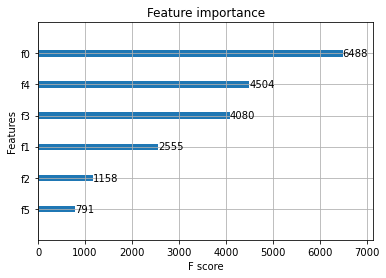

In [10]:
if(MAKE_PREDICTIONS_XGB):
    #define model parameters
    xgb_params = {}
    xgb_params['eta']=0.3
    xgb_params['tree_method']= "hist"
    xgb_params['grow_policy']= "lossguide"
    xgb_params['max_leaves']= 1400
    xgb_params['max_depth']=0 
    xgb_params['subsample']= 0.9
    xgb_params['colsample_bytree']=0.7
    xgb_params['colsample_bylevel']=0.7
    xgb_params['min_child_weight']=0
    xgb_params['alpha']=4
    xgb_params['objective']= 'binary:logistic'
    xgb_params['scale_pos_weight']=9
    xgb_params['eval_metric']= 'auc' 
    xgb_params['nthread']=8
    xgb_params['random_state']= 99 
    xgb_params['silent']= True
    #define model
    xgb = XGBClassifier(**xgb_params)
    del xgb_params
    gc.collect()
    #define evaluation procedure
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
    #evaluate model
    scores = cross_val_score(xgb, X, y, scoring='roc_auc', cv=cv, n_jobs=-1)
    #summarize performance
    print('XGBoost => Mean ROC AUC: %.5f' % np.mean(scores))
    #fit over train
    xgb.fit(X, y)
    plot_importance(xgb)


fit RandomForestClassifier

In [11]:
if(MAKE_PREDICTIONS_RDF):
    #define model parameters
    rdf_params={}
    rdf_params['bootstrap']=True
    rdf_params['class_weight'] = dict({0:1, 1:10000})
    rdf_params['criterion']='gini'
    rdf_params['max_depth']=8
    rdf_params['max_features']='auto'
    rdf_params['max_leaf_nodes']=None
    rdf_params['min_impurity_decrease']=0.0
    rdf_params['min_impurity_split']=None
    rdf_params['min_samples_leaf']=4 
    rdf_params['min_samples_split']=10
    rdf_params['min_weight_fraction_leaf']=0.0 
    rdf_params['n_estimators']=300
    rdf_params['oob_score']=False
    rdf_params['random_state']=42
    rdf_params['verbose']=0
    rdf_params['warm_start']=False
    #define model
    rdf = RandomForestClassifier(**rdf_params)
    del rdf_params
    gc.collect()
    #define evaluation procedure
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
    #evaluate model
    scores = cross_val_score(rdf, X, y, scoring='roc_auc', cv=cv, n_jobs=-1)
    #summarize performance
    print('RandomForest => Mean ROC AUC: %.5f' % np.mean(scores))
    #fit over train
    rdf.fit(X, y)

RandomForest => Mean ROC AUC: 0.95838


fit lightGBM on an imbalanced classification dataset

In [12]:
if(MAKE_PREDICTIONS_LGB):
    #define model parameters
    lgb_params={}
    lgb_params['learning_rate']=0.03
    lgb_params['boosting_type']='gbdt' #GradientBoostingDecisionTree
    lgb_params['objective']='binary' #Binary target feature
    lgb_params['metric']='binary_logloss' #metric for binary classification
    lgb_params['max_depth']=10
    #define model 
    lgb = LGBMClassifier(**lgb_params)
    del lgb_params
    gc.collect()
    #define evaluation procedure
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
    #evaluate model
    scores = cross_val_score(lgb, X, y, scoring='roc_auc', cv=cv, n_jobs=-1)
    #summarize performance
    print('LightGBM => Mean ROC AUC: %.5f' % np.mean(scores))
    #fit over train
    lgb.fit(X, y)

LightGBM => Mean ROC AUC: 0.96996


predict and store results using different classifiers

In [13]:
del X, y
gc.collect()
#prepare testing dataset
test = read('/kaggle/input/talkingdata-adtracking-fraud-detection/test.csv')
test = preprocess(test)

In [14]:
if(MAKE_PREDICTIONS_XGB):
    #predict over test
    prediction = xgb.predict(test.values)
    #store predictions
    submission = pd.DataFrame(data=prediction, index=test.index, columns=['is_attributed'])
    submission.to_csv('submission_xgboost.csv')
    del xgb, submission
    gc.collect()

In [15]:
if(MAKE_PREDICTIONS_RDF):
    #predict over test
    prediction = rdf.predict(test.values)
    #store predictions
    submission = pd.DataFrame(data=prediction, index=test.index, columns=['is_attributed'])
    submission.to_csv('submission_random_forest.csv')
    del rdf, submission
    gc.collect()

NameError: name 'sumbission' is not defined

In [16]:
if(MAKE_PREDICTIONS_LGB):
    #predict over test
    prediction = lgb.predict(test.values)
    #store predictions
    submission = pd.DataFrame(data=prediction, index=test.index, columns=['is_attributed'])
    submission.to_csv('submission_lightgbm.csv')
    print("The whole notebook took {} seconds to finish".format(int(time()-start_)))
    del lgb, submission, test
    gc.collect()

The whole notebook took 6296 seconds to finish
